In [1]:
# Set some environment variables
import os
gpu_num = 0 # GPU to be used. Use "" to use the CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress some TF warnings
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    os.system("pip install sionna")
    import sionna

# Configure GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
import warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

# Fix the seed for reproducible results
tf.random.set_seed(42)

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera
from sionna.phy import ofdm,channel,mapping,utils

# For link-level simulations
from sionna.phy.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset, AWGN, RayleighBlockFading
from sionna.phy.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.phy.utils import compute_ber, ebnodb2no, PlotBER
from sionna.phy.ofdm import KBestDetector, LinearDetector
from sionna.phy.mimo import StreamManagement
import scipy.special as sp

# For the implementation of the Keras models
from tensorflow.keras import Model

In [4]:
BATCH_SIZE = 100
NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 1

NUM_STREAMS_PER_TX = NUM_UT_ANT

NUM_BITS_PER_SYMBOL = 4
CODERATE = 1

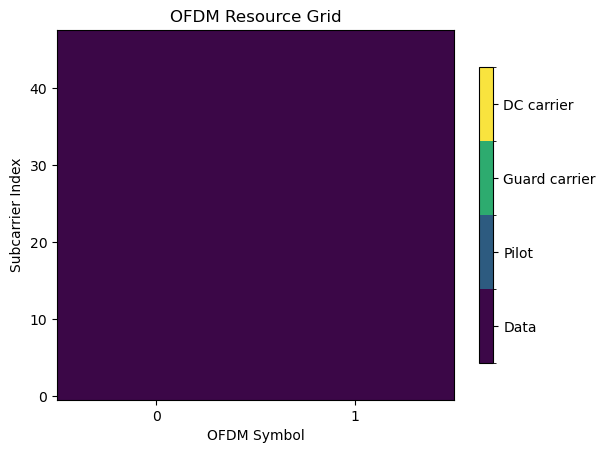

In [7]:
RESOURCE_GRID = ofdm.ResourceGrid( num_ofdm_symbols=2,
                                      fft_size=48,
                                      subcarrier_spacing=15e3,
                                      num_tx=NUM_UT,
                                      num_streams_per_tx=NUM_STREAMS_PER_TX,
                                      cyclic_prefix_length=6,
                                      pilot_pattern= None,
                                      pilot_ofdm_symbol_indices= None)
RESOURCE_GRID.show();

In [8]:
# Number of coded bits in a resource grid
n = int(RESOURCE_GRID.num_data_symbols*NUM_BITS_PER_SYMBOL)

print(n)
# Number of information bits in a resource groud
k = int(n*CODERATE)
print(k)

384
384


In [15]:
rayleigh = RayleighBlockFading(num_rx = 1,
                               num_rx_ant = 1,
                               num_tx = 1,
                               num_tx_ant = 1)

gen_channel  = channel.GenerateOFDMChannel(channel_model = rayleigh,
                       resource_grid = RESOURCE_GRID)

channel  = channel.OFDMChannel(channel_model = rayleigh,
                       resource_grid = RESOURCE_GRID)

apply_channel = ApplyOFDMChannel()

binary_source = mapping.BinarySource()

constellation = mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

# The mapper maps blocks of information bits to constellation symbols
mapper = mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ofdm.ResourceGridMapper(RESOURCE_GRID)

# The demapper produces LLR for all coded bits
demapper = mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL, hard_out = True)

#encoder = sionna.fec.conv.ConvEncoder() # constraint length of the code
#decoder = sionna.fec.conv.ViterbiDecoder() # the code parameters are infered from the encoder

#mapper_1 = sionna.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
#demapper_1 = sionna.mapping.Demapper("app", constellation=constellation)

In [17]:
bits = binary_source([BATCH_SIZE, NUM_UT, NUM_STREAMS_PER_TX , k])
print(bits)

# The mapper maps blocks of information bits to constellation symbols
x = mapper(bits)
print(x.shape)

x_rg = rg_mapper(x)
print("Shape of x_rg (mapping in Resource Grid): ", x_rg.shape)

no = utils.ebnodb2no(ebno_db= 20,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=CODERATE)

print(no)

a, tau = rayleigh(batch_size = BATCH_SIZE, num_time_steps = 1, sampling_frequency=RESOURCE_GRID.bandwidth)
print(a.shape)
print(tau.shape)

frequencies = subcarrier_frequencies(RESOURCE_GRID.fft_size, RESOURCE_GRID.subcarrier_spacing)
h = cir_to_ofdm_channel(frequencies, a, tau)
print(h.shape)

y = channel([x_rg, no])
print(y.shape)

bits_hat = demapper([y, no])
print(bits_hat)

tf.Tensor(
[[[[0. 0. 1. ... 0. 1. 1.]]]


 [[[1. 1. 1. ... 1. 1. 1.]]]


 [[[1. 1. 1. ... 0. 0. 1.]]]


 ...


 [[[0. 1. 1. ... 0. 1. 0.]]]


 [[[0. 0. 0. ... 1. 0. 0.]]]


 [[[0. 1. 1. ... 1. 1. 0.]]]], shape=(100, 1, 1, 384), dtype=float32)
(100, 1, 1, 96)
Shape of x_rg (mapping in Resource Grid):  (100, 1, 1, 2, 48)
tf.Tensor(0.0025, shape=(), dtype=float32)
(100, 1, 1, 1, 1, 1, 1)
(100, 1, 1, 1)
(100, 1, 1, 1, 1, 1, 48)


InvalidArgumentError: cannot compute Pack as input #1(zero-based) was expected to be a complex64 tensor but is a float tensor [Op:Pack] name: packed

In [ ]:
t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

In [ ]:
h_sample = h[0, :, :, :, :, :, :]
h_freq = tf.squeeze(h_sample)
print(h_freq.shape)

plt.figure()
plt.plot(np.real(h_freq), "-")
plt.plot(np.imag(h_freq), "-")
plt.xlabel("Subcarrier index")
plt.ylabel(r"Channel frequency response")
plt.legend(["OFDM Channel (real)", "OFDM Channel (imag)"])

In [ ]:
# Select one batch from y and the first index along num_rx and num_rx_ant dimensions
y_sample = y[40, 0, 0, :, :]
print(y_sample.shape)

plt.figure(figsize=(8, 8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(y_sample), tf.math.imag(y_sample))
plt.tight_layout()
plt.show()

In [ ]:
# Select one batch from y and the first index along num_rx and num_rx_ant dimensions
bits_hat_1 = bits_hat[:, :, 0, :, :]
print(bits_hat_1.shape)

plt.figure(figsize=(8, 8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(bits_hat_1), tf.math.imag(bits_hat_1))
plt.tight_layout()
plt.show()

In [ ]:
num_samples = 20 # how many samples shall be printed
num_symbols = int(num_samples/NUM_BITS_PER_SYMBOL)

print(f"First {num_samples} transmitted bits: {bits[0,0,0,:num_samples]}")
print(f"First {num_symbols} transmitted symbols: {np.round(x[0,0,0,:num_symbols], 2)}")
print(f"First {num_symbols} received symbols: {np.round(y[0,0,0,:num_symbols], 2)}")
#print(f"First {num_samples} demapped llrs: {np.round(llr[0,0,0,:num_samples], 2)}")
print(f"First {num_samples} Received symbols: {np.round(bits_hat[0,0,0,:num_samples], 2)}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sp
import scipy.stats as stats

# Define the range of SNRs
snr_range_db = np.arange(-3, 40)  # Range from -3 dB to 10 dB

# Placeholder to store BER values
ber_values = []

for ebno_db in snr_range_db:
    # Convert dB to noise power ratio
    no = sionna.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                coderate=CODERATE)
    # Transmitter
    y = channel([x_rg, no])  # Simulate channel output
    bits_hat = demapper([y , no])
    bits_hat_1 = bits_hat[:, :, 0, :, :]
    ber = compute_ber(bits, bits_hat_1).numpy()
    print(f"SNR(dB): {ebno_db}, BER: {ber:.5f}")
    ber_values.append(ber)

# Calculate theoretical BER
M = 4
sqrtM = np.sqrt(M)
SNR = 10 ** (snr_range_db / 10)
Ps = 1 - (1 - 2 * (sqrtM - 1) / sqrtM * stats.norm.sf(np.sqrt(3 * SNR / (M - 1))))**2
BER_th = Ps/2

# Plot BER curves
plt.figure()
plt.semilogy(snr_range_db, ber_values, marker='o', label='Simulated BER')
plt.semilogy(snr_range_db, BER_th, marker='o', label='Theoretical BER')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('Bit Error Rate vs. Signal-to-Noise Ratio (SNR)')
plt.grid(True)
plt.legend()
plt.show()